In [1]:
from PIL import Image as PILImage
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.origin'] = 'lower'  # we want to show images, not matrices, so we set the origin to the lower-left
plt.matplotlib.style.use('dark_background') 

from astropy import units as u
from astropy.io import fits
from astropy.modeling.polynomial import Polynomial1D
from astropy.modeling.models import Gaussian1D, Linear1D
from astropy.modeling.fitting import LinearLSQFitter, LevMarLSQFitter
from IPython.display import Image
from astropy.table import Table

# astroquery provides an interface to the NIST atomic line database
from astroquery.nist import Nist
from astropy.io import fits

import glob
import os
from astropy.visualization import ZScaleInterval

from pathlib import Path

import lacosmic
from astropy.nddata import CCDData
import ccdproc

### Block from astropy ccd data reduction guide

In [2]:
from astropy.nddata.blocks import block_reduce
from astropy import visualization as aviz

imstats = lambda dat: (dat.min(), dat.max(), dat.mean(), dat.std())


def show_image(image,
               percl=99, percu=None, is_mask=False,
               figsize=(10, 10),
               cmap='viridis', log=False, clip=True,
               show_colorbar=True, show_ticks=True,
               fig=None, ax=None, input_ratio=None):
    """
    Show an image in matplotlib with some basic astronomically-appropriat stretching.

    Parameters
    ----------
    image
        The image to show
    percl : number
        The percentile for the lower edge of the stretch (or both edges if ``percu`` is None)
    percu : number or None
        The percentile for the upper edge of the stretch (or None to use ``percl`` for both)
    figsize : 2-tuple
        The size of the matplotlib figure in inches
    """
    if percu is None:
        percu = percl
        percl = 100 - percl

    if (fig is None and ax is not None) or (fig is not None and ax is None):
        raise ValueError('Must provide both "fig" and "ax" '
                         'if you provide one of them')
    elif fig is None and ax is None:
        if figsize is not None:
            # Rescale the fig size to match the image dimensions, roughly
            image_aspect_ratio = image.shape[0] / image.shape[1]
            figsize = (max(figsize) * image_aspect_ratio, max(figsize))

        fig, ax = plt.subplots(1, 1, figsize=figsize)


    # To preserve details we should *really* downsample correctly and
    # not rely on matplotlib to do it correctly for us (it won't).

    # So, calculate the size of the figure in pixels, block_reduce to
    # roughly that,and display the block reduced image.

    # Thanks, https://stackoverflow.com/questions/29702424/how-to-get-matplotlib-figure-size
    fig_size_pix = fig.get_size_inches() * fig.dpi

    ratio = (image.shape // fig_size_pix).max()

    if ratio < 1:
        ratio = 1

    ratio = input_ratio or ratio

    reduced_data = block_reduce(image, ratio)

    if not is_mask:
        # Divide by the square of the ratio to keep the flux the same in the
        # reduced image. We do *not* want to do this for images which are
        # masks, since their values should be zero or one.
         reduced_data = reduced_data / ratio**2

    # Of course, now that we have downsampled, the axis limits are changed to
    # match the smaller image size. Setting the extent will do the trick to
    # change the axis display back to showing the actual extent of the image.
    extent = [0, image.shape[1], 0, image.shape[0]]

    if log:
        stretch = aviz.LogStretch()
    else:
        stretch = aviz.LinearStretch()

    norm = aviz.ImageNormalize(reduced_data,
                               interval=aviz.AsymmetricPercentileInterval(percl, percu),
                               stretch=stretch, clip=clip)

    if is_mask:
        # The image is a mask in which pixels should be zero or one.
        # block_reduce may have changed some of the values, so reset here.
        reduced_data = reduced_data > 0
        # Set the image scale limits appropriately.
        scale_args = dict(vmin=0, vmax=1)
    else:
        scale_args = dict(norm=norm)

    im = ax.imshow(reduced_data, origin='lower',
                   cmap=cmap, extent=extent, aspect='equal', **scale_args)

    if show_colorbar:
        # I haven't a clue why the fraction and pad arguments below work to make
        # the colorbar the same height as the image, but they do....unless the image
        # is wider than it is tall. Sticking with this for now anyway...
        # Thanks: https://stackoverflow.com/a/26720422/3486425
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        # In case someone in the future wants to improve this:
        # https://joseph-long.com/writing/colorbars/
        # https://stackoverflow.com/a/33505522/3486425
        # https://matplotlib.org/mpl_toolkits/axes_grid/users/overview.html#colorbar-whose-height-or-width-in-sync-with-the-master-axes

    if not show_ticks:
        ax.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)


def avg_over_images(masked_arr, axis=0):
    """
    Calculate average pixel value along specified axis
    """
    return ma.mean(masked_arr, axis=axis)

def med_over_images(masked_arr, axis=0):
    """
    Calculate median pixel value along specified axis
    
    Uses bottleneck.nanmedian for speed
    """
    
    dat = masked_arr.data.copy()
    dat[masked_arr.mask] = np.NaN
    return bn.nanmedian(dat, axis=axis)

### end of that block

# Start with M1

In [3]:
calibrated_data = Path('.', 'reduced_data')
calibrated_data.mkdir(exist_ok=True)
raw_darks = ccdproc.ImageFileCollection('../soar/darks')
raw_m1 = ccdproc.ImageFileCollection('../soar/m1/')
raw_m5 = ccdproc.ImageFileCollection('../soar/m5/')
darks = raw_darks.files_filtered(include_path=True)
m1 = raw_m1.files_filtered(include_path=True)
m5 = raw_m5.files_filtered(include_path=True)

raw_m1.summary['file', 'detsize', 'trimsec', 'ccdsize']

<Table length=2>
       file            detsize         trimsec          ccdsize    
      str18             str15           str16            str15     
------------------ --------------- ---------------- ---------------
     0115_sci.fits [1:4096,1:4096] [51:4110,2:1896] [1:4096,1:4096]
0117_sci_lamp.fits [1:4096,1:4096] [51:4110,2:1896] [1:4096,1:4096]

In [4]:
def overscan_and_trim(filelist):
    for num, file in enumerate(filelist):
        if (num>4):
            filename=file[11:]
        else:
            filename=file[14:]
        print(filename)
        file_data = CCDData.read(file, unit='adu')
        overscan_subtracted = ccdproc.subtract_overscan(file_data, overscan=file_data[:1, 4130:], median=True)
        trimmed = ccdproc.trim_image(overscan_subtracted[1:, 52:4110])
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
        show_image(file_data, cmap='gray', ax=ax1, fig=fig)
        ax1.set_title(f'Raw')
        print(np.shape(trimmed))
        show_image(trimmed, cmap='gray', ax=ax2, fig=fig)
        ax2.set_title(f'overscan subtracted and trimmed')
        plt.show()
        plt.close()
        trimmed.write(calibrated_data / filename, overwrite='True', format='fits')

In [5]:
all = darks + m1 + m5
all

['../soar/darks/0026_dark.fits',
 '../soar/darks/0027_dark.fits',
 '../soar/darks/0028_dark.fits',
 '../soar/darks/0029_dark.fits',
 '../soar/darks/0030_dark.fits',
 '../soar/m1/0115_sci.fits',
 '../soar/m1/0117_sci_lamp.fits',
 '../soar/m5/0119_sci.fits',
 '../soar/m5/0120_sci_lamp.fits']

0026_dark.fits
(1895, 4058)


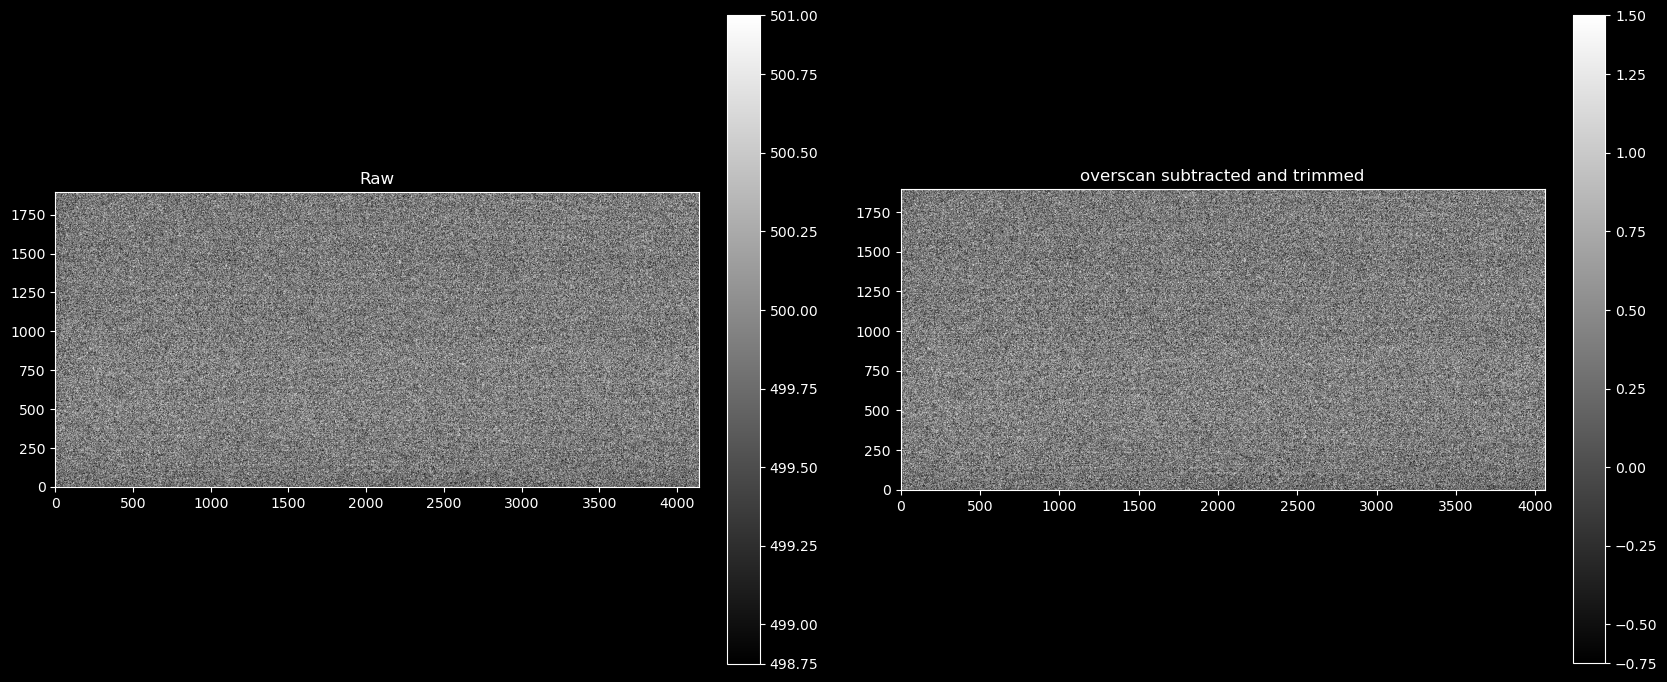

0027_dark.fits
(1895, 4058)


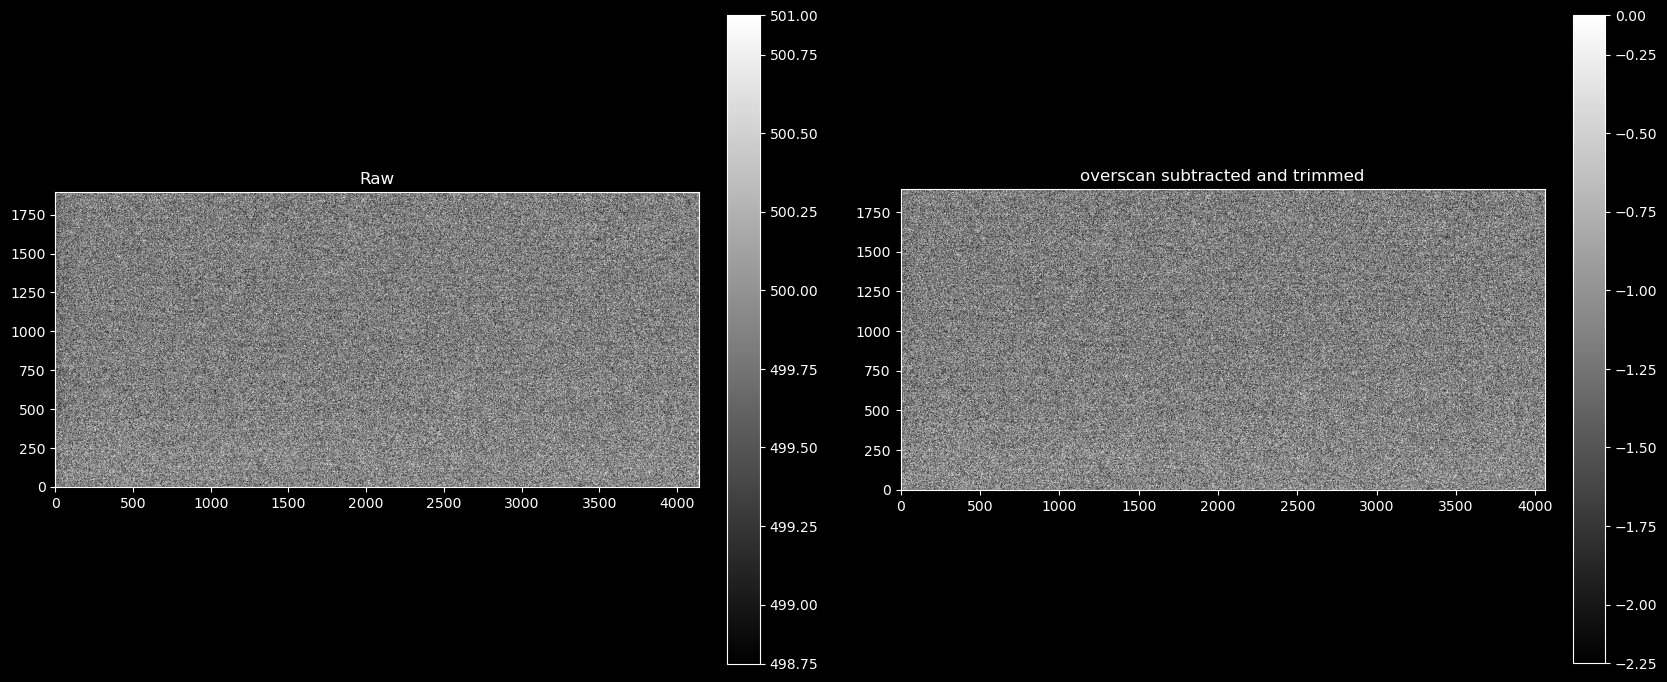

0028_dark.fits
(1895, 4058)


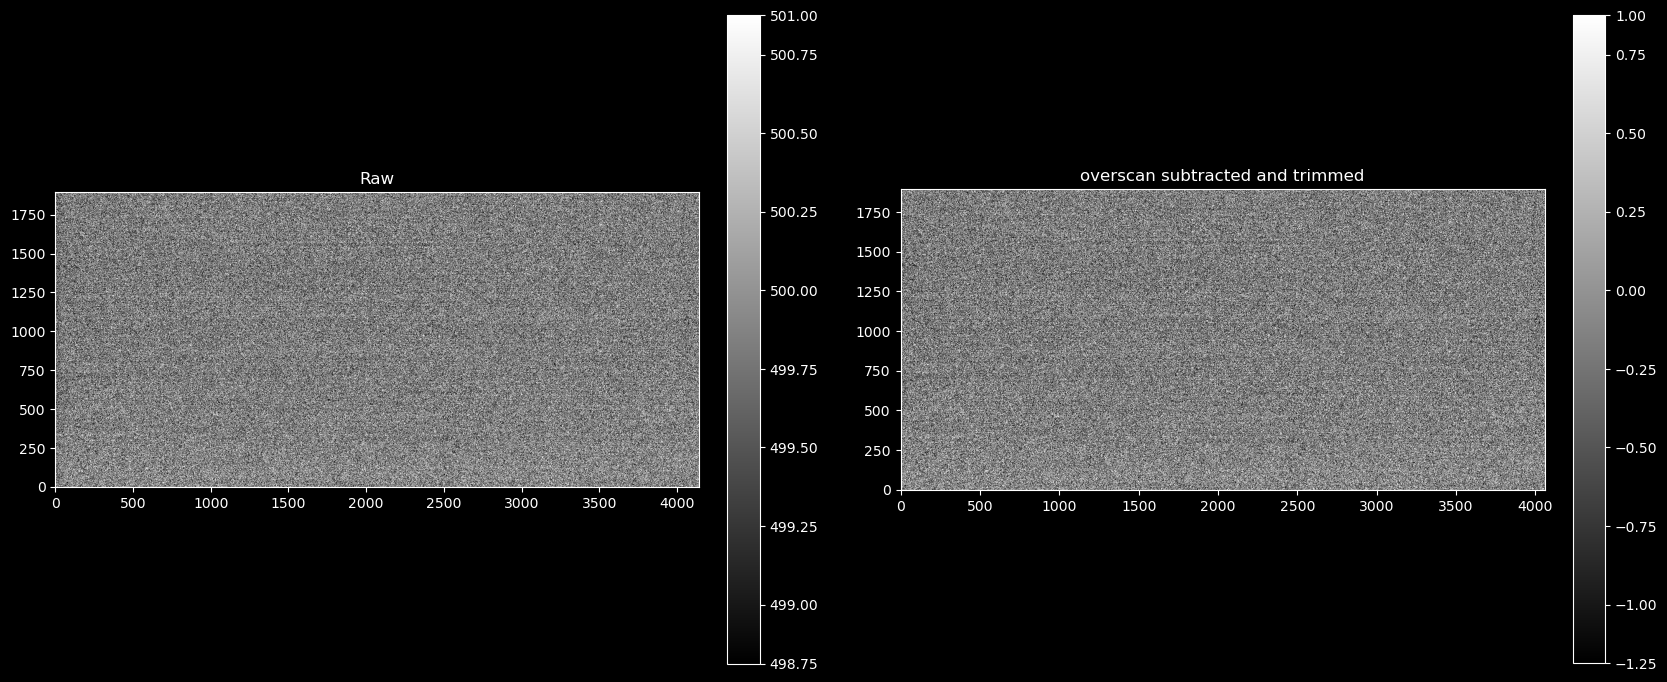

0029_dark.fits
(1895, 4058)


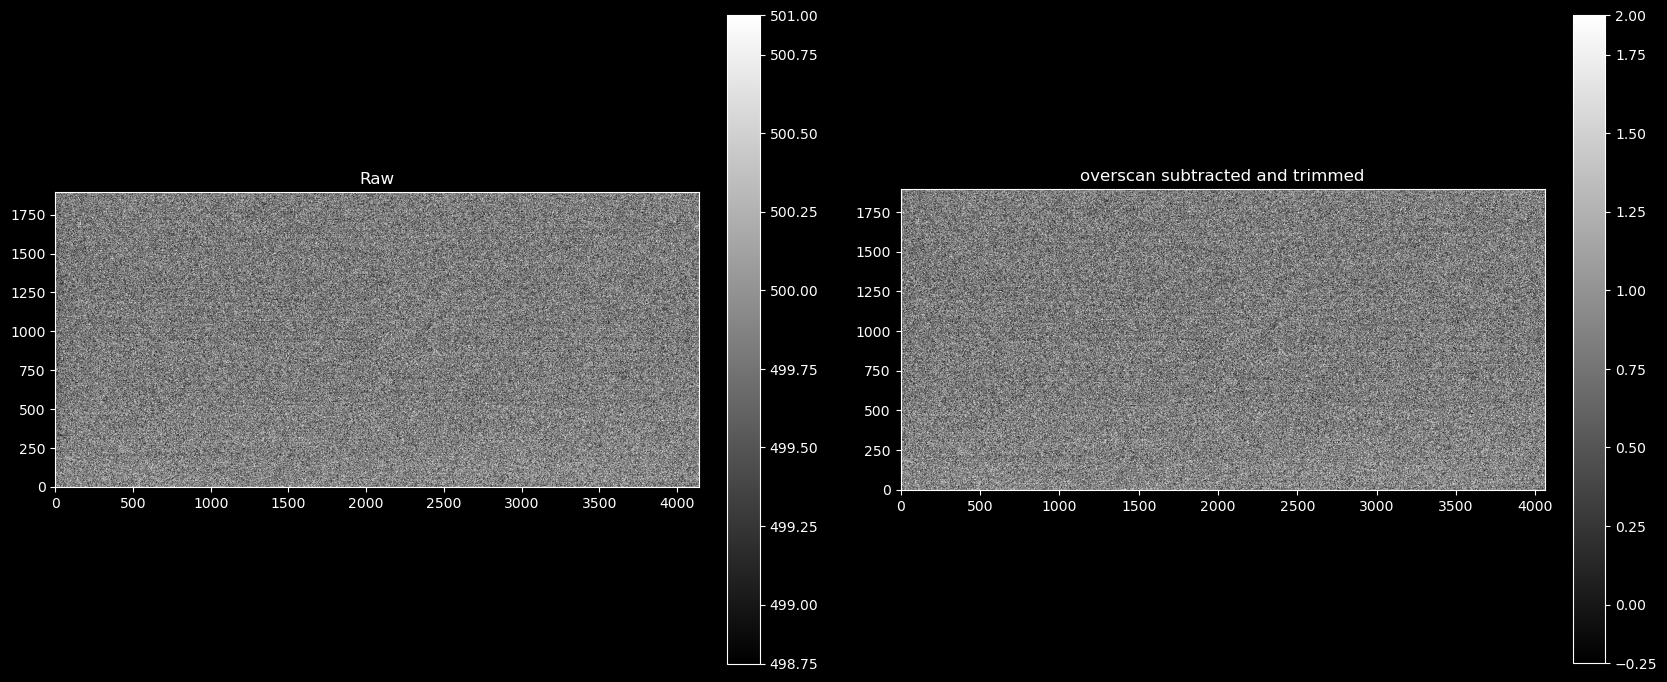

0030_dark.fits
(1895, 4058)


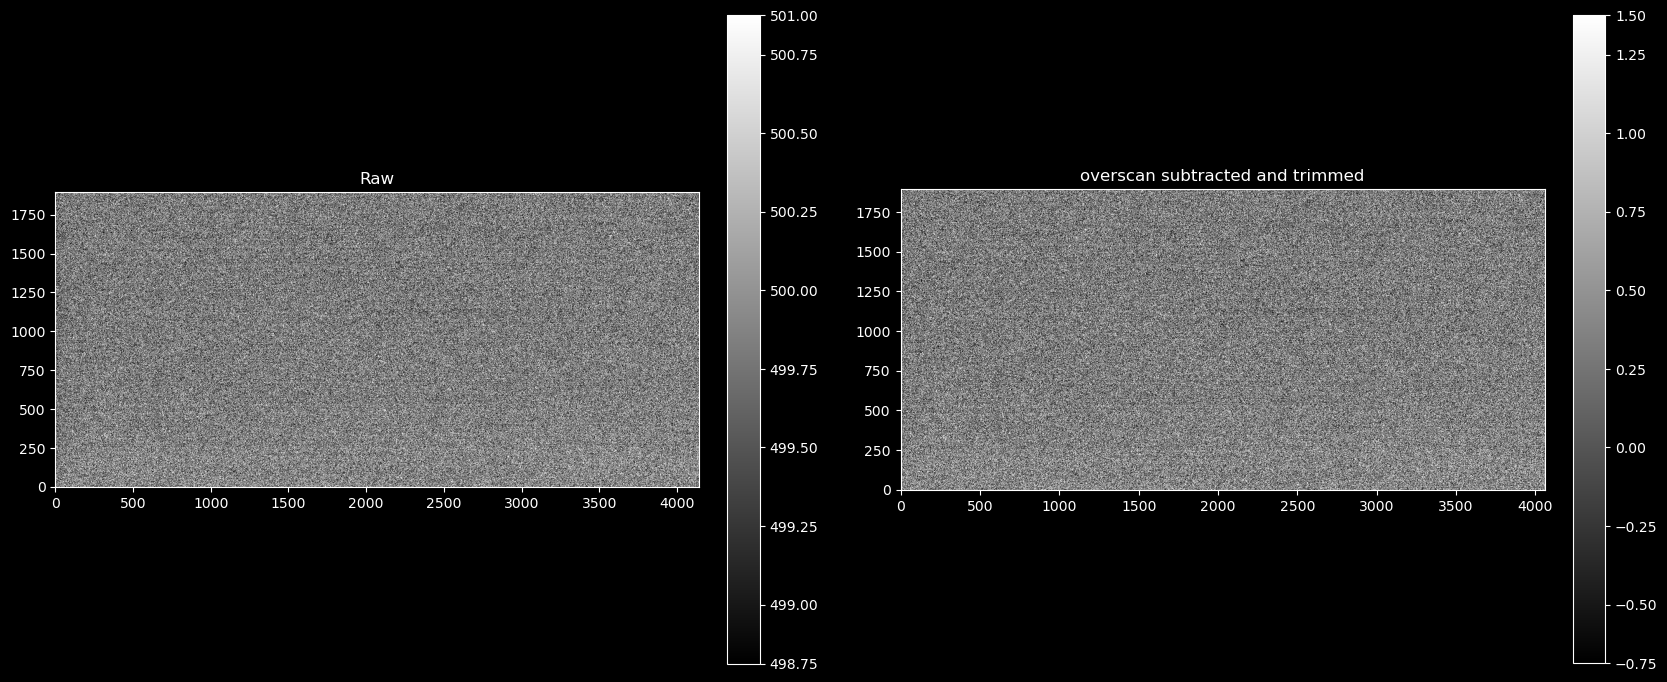

0115_sci.fits
(1895, 4058)


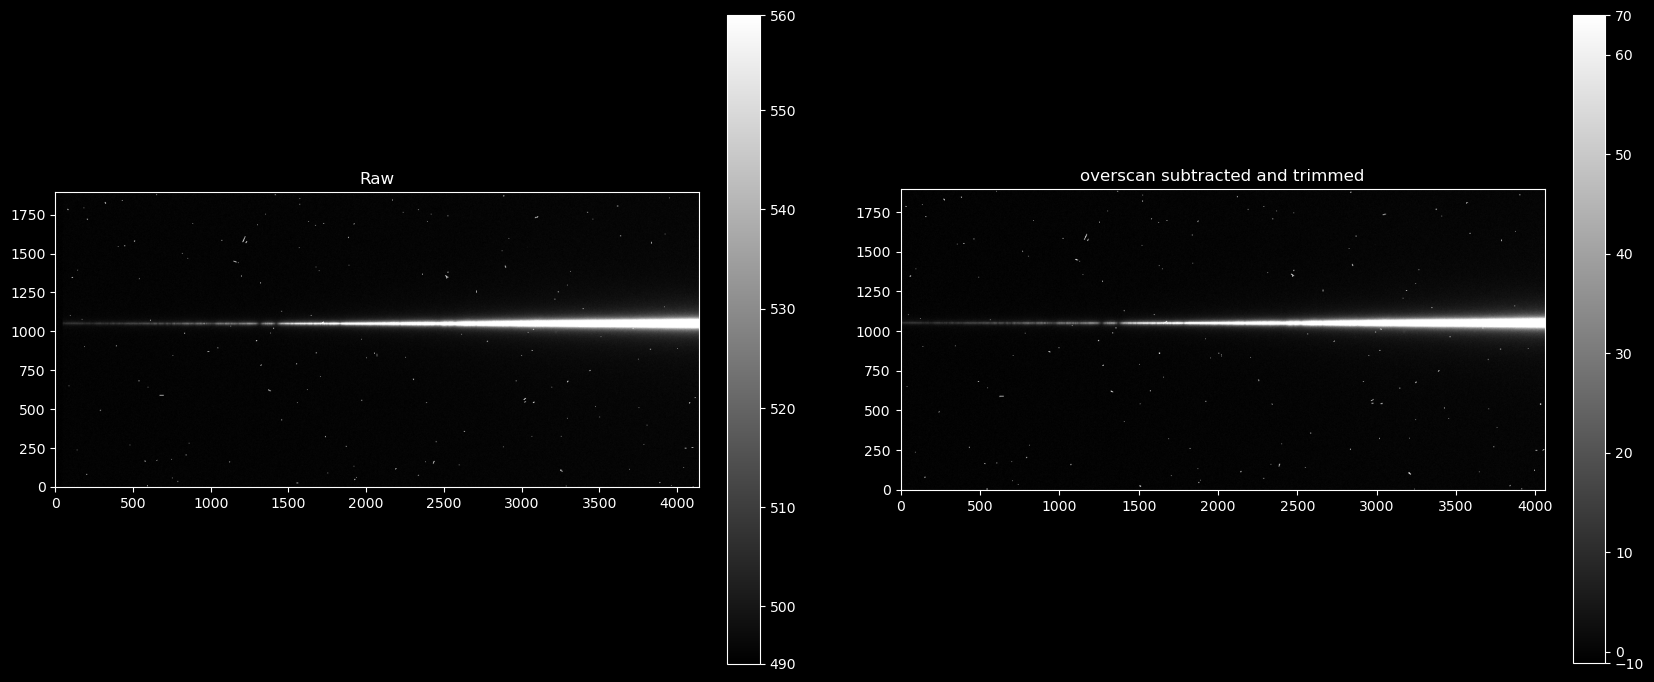

0117_sci_lamp.fits
(1895, 4058)


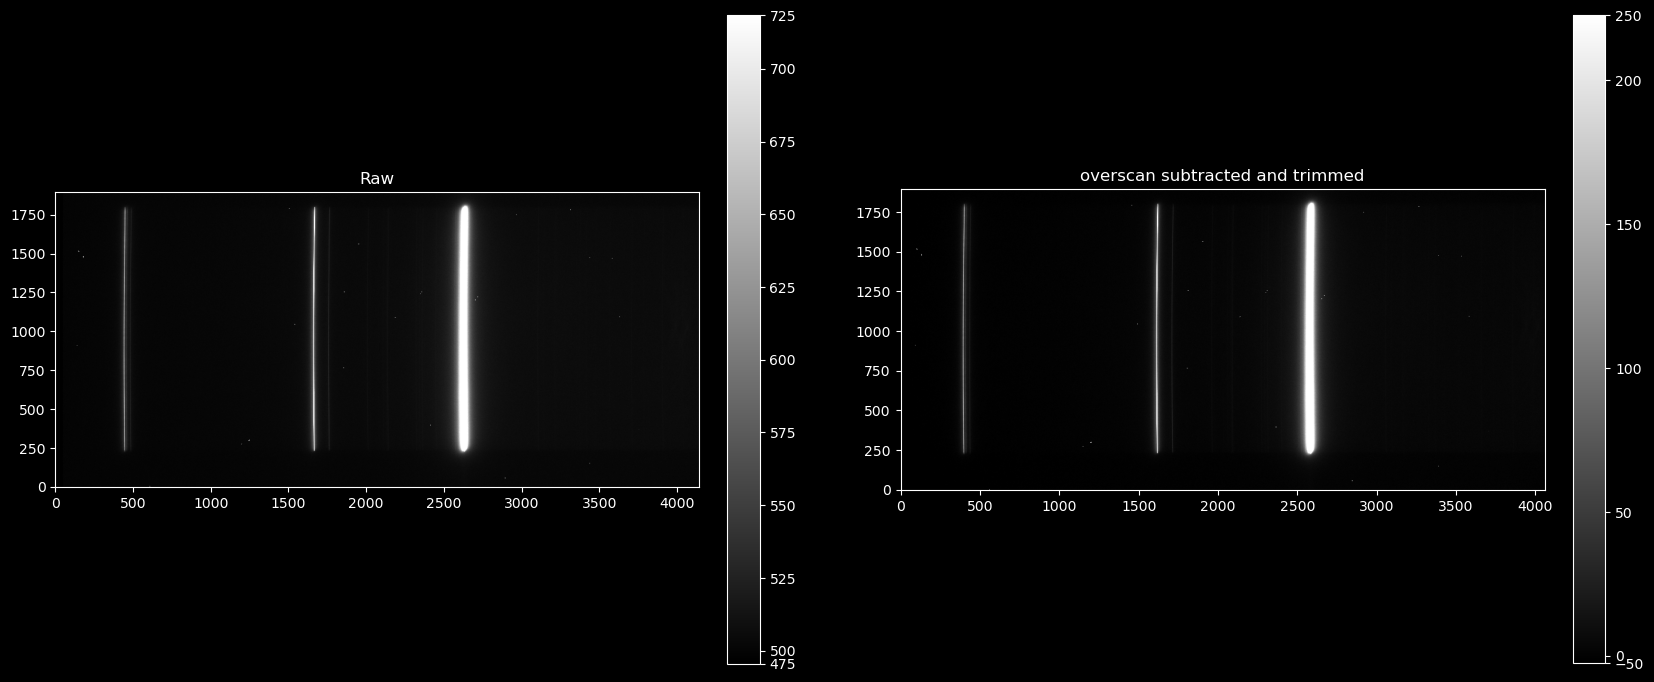

0119_sci.fits
(1895, 4058)


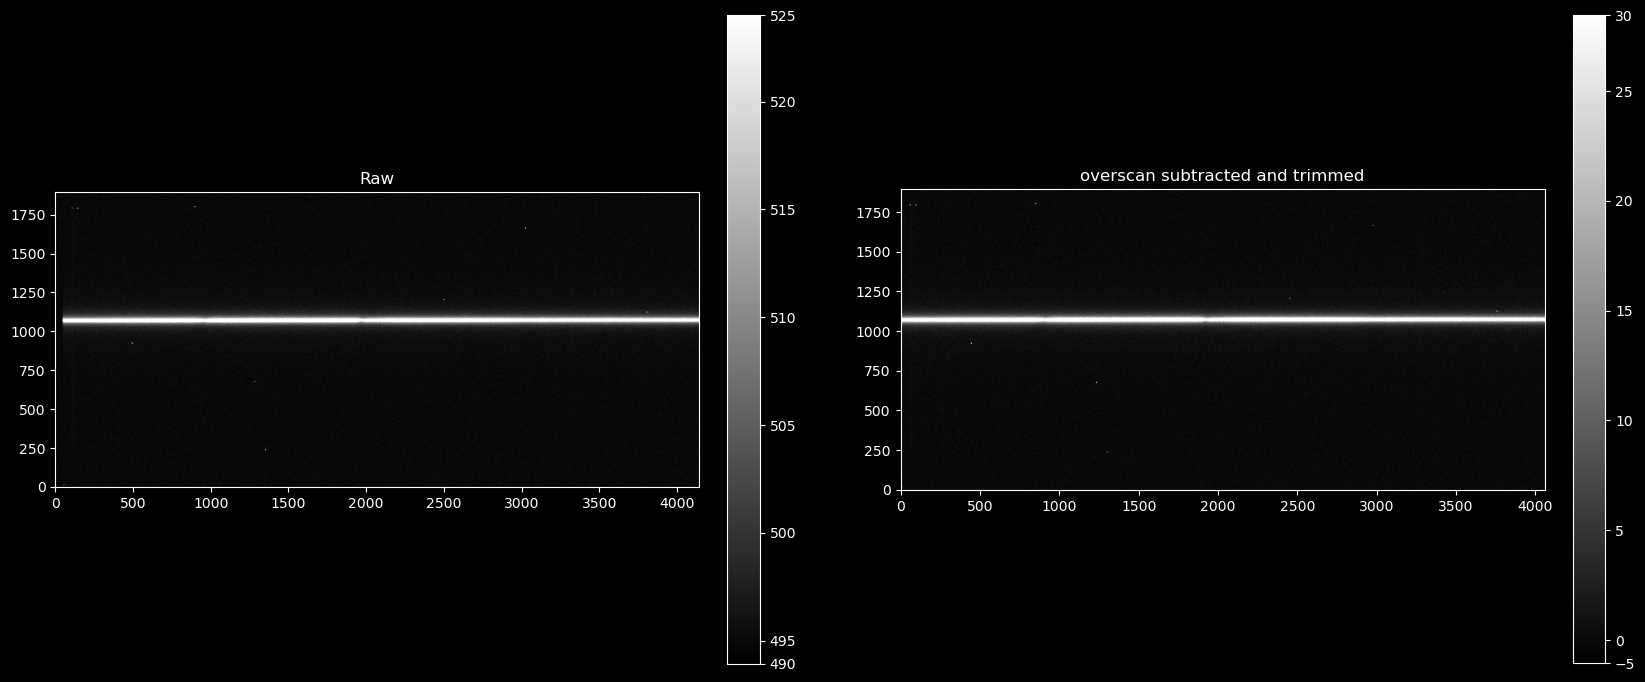

0120_sci_lamp.fits
(1895, 4058)


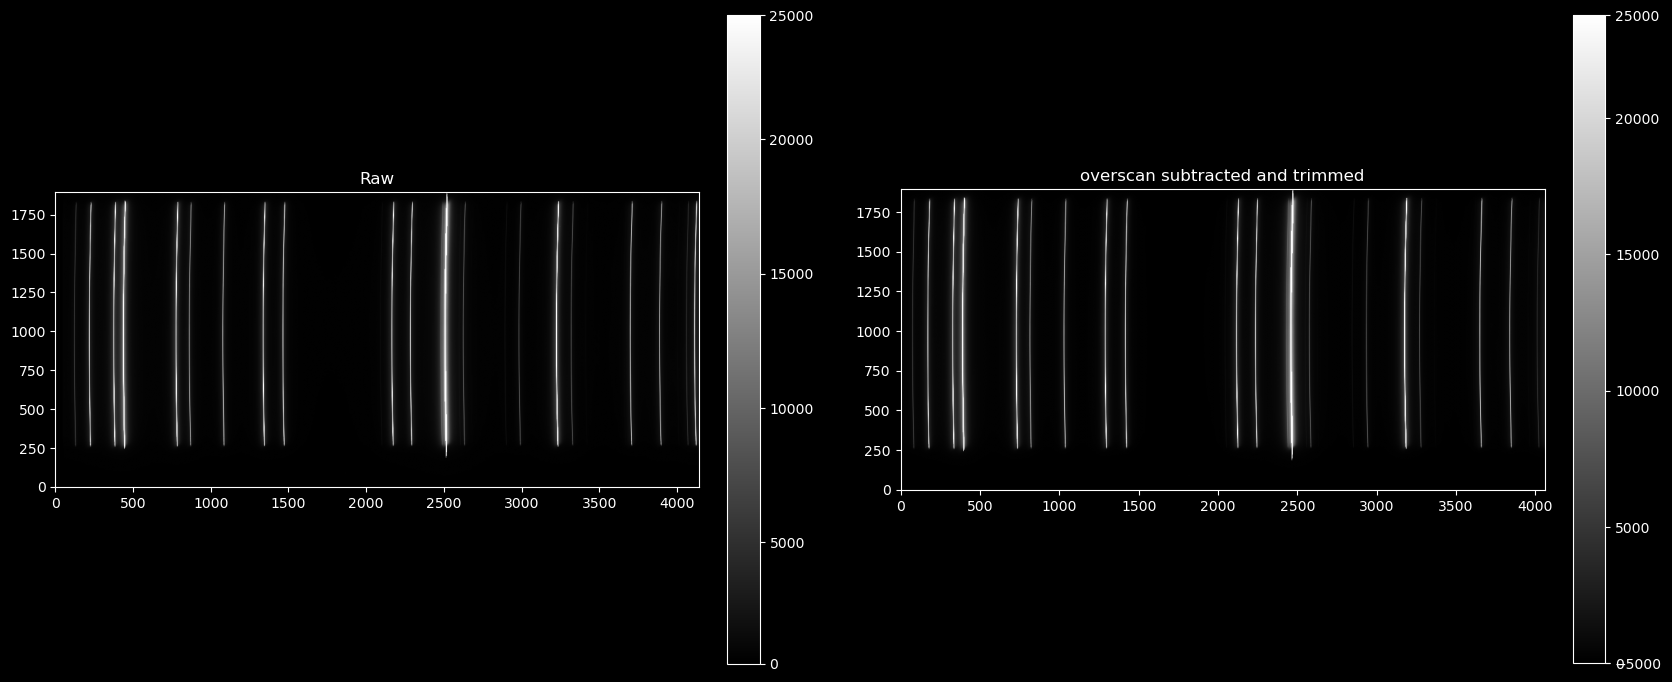

In [6]:
overscan_and_trim(all)

In [7]:
reduced_images = ccdproc.ImageFileCollection(calibrated_data)
calibrated_darks = reduced_images.files_filtered(obstype='DARK', exptime=1, include_path=True)

combined_dark = ccdproc.combine(calibrated_darks, method='median',
                                sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                sigma_clip_func=np.ma.median, sigma_clip_dev_func='mad_std')

In [8]:
combined_dark.meta['combined'] = True
dark_file_name = '../reduced_data/combined_dark.fits'
combined_dark.write(calibrated_data / dark_file_name, overwrite=True)

In [9]:
reduced_images = ccdproc.ImageFileCollection(calibrated_data)
science_and_wl = reduced_images.files_filtered(obstype='OBJECT', include_path=True)
science_m1 = CCDData.read(science_and_wl[0], unit='adu')
science_m5 = CCDData.read(science_and_wl[2], unit='adu')

gaincheck_m1 = fits.open(science_and_wl[0])
gain_m1 = gaincheck_m1[0].header['GAIN']
gaincheck_m5 = fits.open(science_and_wl[2])
gain_m5 = gaincheck_m5[0].header['GAIN']

rdnoise_m1 = gaincheck_m1[0].header['RDNOISE']
rdnoise_m5 = gaincheck_m5[0].header['RDNOISE']

del gaincheck_m5, gaincheck_m1

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


In [10]:
star_m1_darksub = ccdproc.subtract_dark(science_m1, combined_dark, dark_exposure=1*u.s, data_exposure=240*u.s,  exposure_unit=u.second)
star_m5_darksub = ccdproc.subtract_dark(science_m5, combined_dark, dark_exposure=1*u.s, data_exposure=10*u.s,  exposure_unit=u.second)

gain_corrected_m1 = ccdproc.gain_correct(star_m1_darksub, gain_m1)
gain_corrected_m5 = ccdproc.gain_correct(star_m5_darksub, gain_m5)

In [11]:
cosmic_rays_removed_m1 = ccdproc.cosmicray_lacosmic(gain_corrected_m1, readnoise=rdnoise_m1, sigclip=7, verbose=True)
cosmic_rays_removed_m5 = ccdproc.cosmicray_lacosmic(gain_corrected_m5, readnoise=rdnoise_m5, sigclip=7, verbose=True)

Starting 4 L.A.Cosmic iterations
Iteration 1:
1401 cosmic pixels this iteration
Iteration 2:
53 cosmic pixels this iteration
Iteration 3:
1 cosmic pixels this iteration
Iteration 4:
0 cosmic pixels this iteration
Starting 4 L.A.Cosmic iterations
Iteration 1:
69 cosmic pixels this iteration
Iteration 2:
5 cosmic pixels this iteration
Iteration 3:
0 cosmic pixels this iteration


Now that cosmic rays have been removed I am gonna write up a function to trace up each spectra individually

In [12]:
linfitter = LinearLSQFitter()
polymodel = Polynomial1D(degree=1)
lmfitter = LevMarLSQFitter()


In [20]:
def trace_extract(image):
    fig, ax = plt.subplots()
    show_image(image, cmap='gray', ax=ax, fig=fig)
    plt.show(block=False)
    image_array = np.array(image)
    min_xtract = int(input("What is the minimum y-axis value to trace?"))
    max_xtract = int(input("What is the maximum y-axis value to trace?"))
    plt.close(fig)
    yaxis = np.repeat(np.arange(min_xtract, max_xtract)[:, None], image.shape[1], axis=1)
    background = np.median(image)
    weighted_yaxis_values = np.average(yaxis, axis=0, 
                                       weights=image_array[min_xtract:max_xtract, :] - background)
    xvals = np.arange(len(weighted_yaxis_values))
    fig, ax = plt.subplots()
    ax.plot(xvals, weighted_yaxis_values, "x")
    ax.set_xlabel("X Coordinate")
    ax.set_ylabel("Moment-1 estimated Y-value trace")
    plt.show(block=False)

    min_bad = int(input("What is the y-axis value below which to throw out?"))
    max_bad = int(input("What is the y-axis value above which to throw out?"))
    bad_moments = (weighted_yaxis_values < min_bad) | (weighted_yaxis_values > max_bad)

    xlims_ornot = input("Do you want to trim out bad x-values? (T/t or F/f)")
    if ((xlims_ornot=='f') | (xlims_ornot=='F') | (xlims_ornot=='n') | (xlims_ornot=='n')):
        fit_polymodel = linfitter(
            polymodel,
            xvals[(~bad_moments)],
            weighted_yaxis_values[(~bad_moments)])
    else:
        min_bad = int(input("What is the x-axis value below which to throw out?"))
        fit_polymodel = linfitter(
            polymodel,
            xvals[(~bad_moments) & (xvals > min_bad)],
            weighted_yaxis_values[(~bad_moments) & (xvals > min_bad)])
    plt.close(fig)
    while True:
        cutout = int(input("How many pixels should we cut"))
        ymini = int(input('What is the smallest yvalue we should plot to show the trace'))
        ymaxi = int(input('What is the biggest yvalue we should plot to show the trace'))

        fig, ax = plt.subplots()
        ax.imshow(image_array[ymini:ymaxi, :], extent=[0, image_array.shape[1], ymini, ymaxi])
        ax.set_aspect(10)
        ax.fill_between(
            xvals,
            fit_polymodel(xvals) - cutout,
            fit_polymodel(xvals) + cutout,
            color="orange",
            alpha=0.2,
        )
        plt.show(block=False)
        good = input('Is this appropriate number of pixels to fill? (Y/y, N/n)')
        if ((good =='Y') | (good=='y')):
            plt.close(fig)
            break
        else:
            plt.close(fig)

    trace_center = fit_polymodel(xvals[~bad_moments])

    cut = np.array([image_array[int(yval)-cutout:int(yval)+cutout, ii]
                         for yval, ii in zip(trace_center, xvals[~bad_moments])])
    mean_trace_profile = (cut - background).mean(axis=0)
    trace_profile_xaxis = np.arange(-cutout, cutout)
    guess = Gaussian1D(amplitude=mean_trace_profile.max(), mean=0, stddev=5)
    fitted_trace_profile = lmfitter(
        model=guess, x=trace_profile_xaxis, y=mean_trace_profile
    )
    model_trace_profile = fitted_trace_profile(trace_profile_xaxis)
    trace_avg_spectrum = np.array(
    [
        np.average(
            image_array[int(yval) - cutout : int(yval) + cutout, ii]
            - background,
            weights=mean_trace_profile,
        )
        for yval, ii in zip(trace_center, xvals[~bad_moments])
    ])
    gaussian_trace_avg_spectrum = np.array(
    [
        np.average(
            image_array[int(yval) - cutout : int(yval) + cutout, ii]
            - background,
            weights=model_trace_profile,
        )
        for yval, ii in zip(trace_center, xvals[~bad_moments])
    ])
    fig, [ax1, ax2] = plt.subplots(2, 1)
    ax1.plot(trace_profile_xaxis, mean_trace_profile, label="data")
    ax1.plot(trace_profile_xaxis, model_trace_profile, label="model")
    ax1.legend(loc="best")
    ax1.set_xlabel("Distance from center")
    ax1.set_ylabel("Average source profile")    
    ax2.plot(trace_avg_spectrum, label="Trace-weighted average")
    ax2.plot(
        gaussian_trace_avg_spectrum,
        label="Gaussian-model",
        alpha=0.5,
        linewidth=0.5,
        color="r",
    )
    ax2.legend(loc="best")
    plt.show(block=False)
    plt.close()
    return fit_polymodel, model_trace_profile

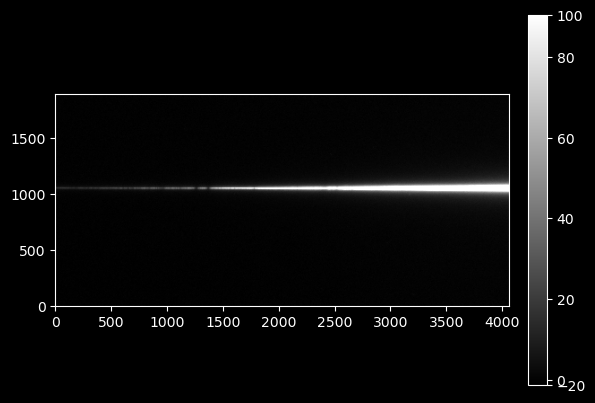

/Users/mschochet/anaconda3/envs/spot/lib/python3.11/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


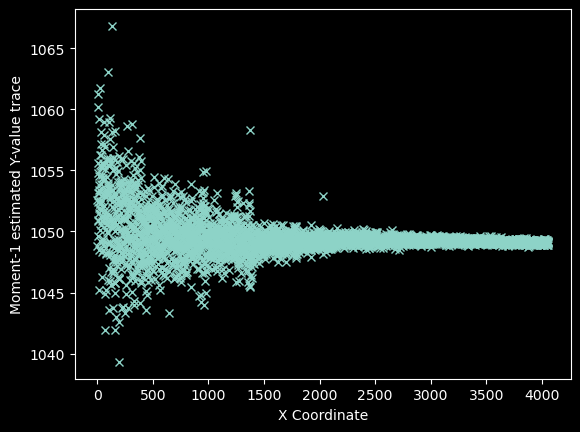

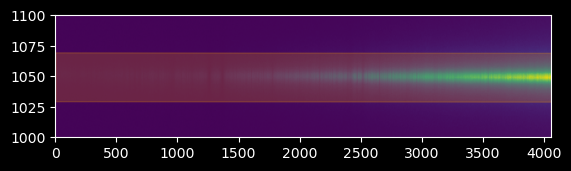

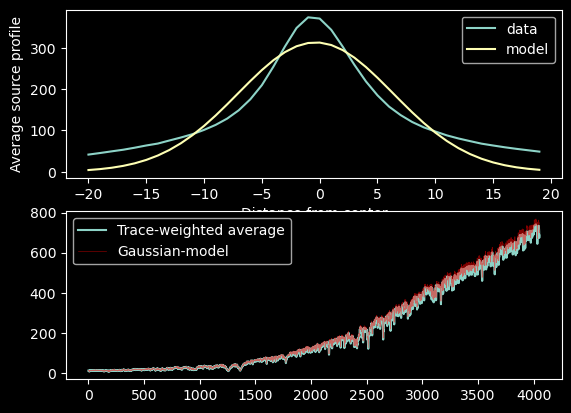

In [21]:
fitted_polymodel_m1, model_trace_profile_m1 = trace_extract(cosmic_rays_removed_m1)

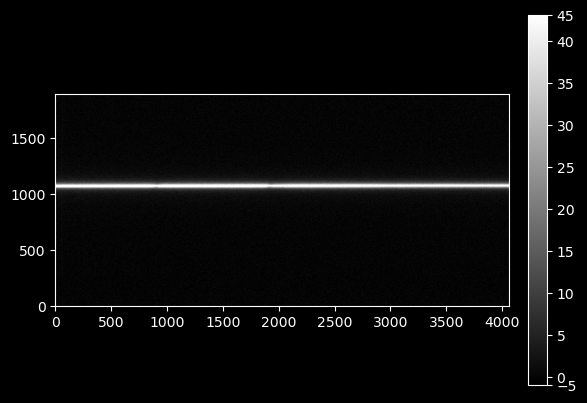

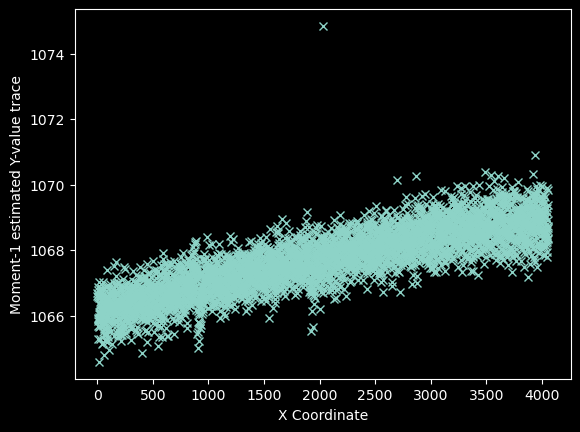

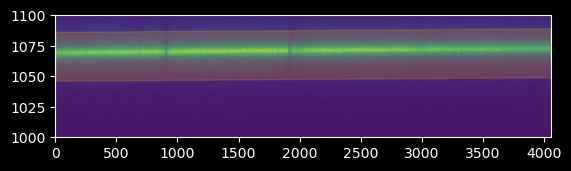

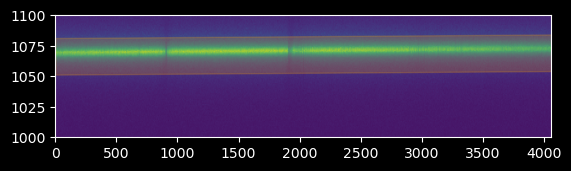

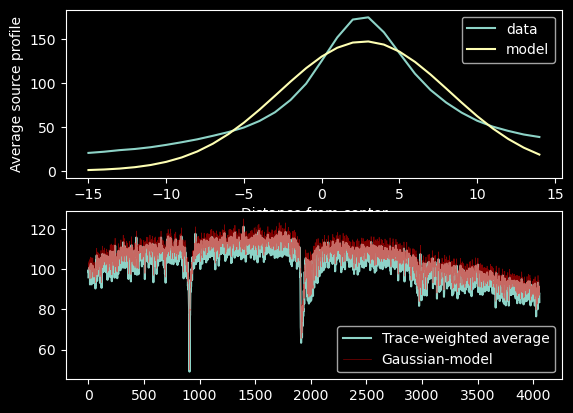

In [22]:
fitted_polymodel_m5, model_trace_profile_m5 = trace_extract(cosmic_rays_removed_m5)